In [1]:
import re
import nltk
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/burakgozutok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/burakgozutok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. Read Data

In [3]:
df = pd.read_csv('recipes.csv', delimiter=';')

# Filter nan columns for Ingredients and Directions
df = df[df['Ingredients'].notnull()]
df = df[df['Directions'].notnull()]
df.Directions = df.Directions.apply(lambda x: x.replace('**', ' '))

df.head(2)

,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID
0,Golden Crescent Rolls Recipe,304,https://images.media-allrecipes.com/userphotos...,Mike A.,25 m,15 m,3 h 10 m,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water. Stir in sugar, s...",7000
1,Poppy Seed Bread with Glaze Recipe,137,https://images.media-allrecipes.com/userphotos...,Christina Jun,15 m,1 h,1 h 20 m,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...,7001


#### Create List of Words from Ingredients and recipies

In [4]:
ingredients_all = list(set([item for row in df.Ingredients for item in row.split(',') if len(item) > 0]))
words_all = [word for row in tqdm(df.Directions.to_list()) for word in nltk.word_tokenize(row)]

len(words_all), len(ingredients_all)

100%|██████████| 12345/12345 [00:09<00:00, 1357.05it/s]


(1245567, 942)

# 2. Prepare Data for Model

#### Train Test Split

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(df, test_size=0.2, random_state=42)
X_val, X_test = train_test_split(X_val, test_size=0.5, random_state=42)

len(X_train), len(X_val), len(X_test)

(9876, 1234, 1235)

#### Split Ingredients and recipes to words seperately for train,test,val

In [31]:
def parse_df(df):
    ingredients_all = list(set([item for row in df.Ingredients for item in row.split(',') if (len(item) > 0 and " " not in item)]))
    words_all = list(set([word for row in tqdm(df.Directions.to_list()) for word in nltk.word_tokenize(row)]))
    
    #Put label 0 to normal words and 1 to ingredients.
    words_0 = list(set(words_all) - set(ingredients_all))
    words_1 = ingredients_all
    
    # Combine 0s and 1s
    x = words_0 + words_1
    y = [0 for i in range(len(words_0))] + [1 for i in range(len(words_0))]
    
    # Shuffle data
    c = list(zip(x, y))
    random.shuffle(c)
    x, y = zip(*c)
    
    assert len(x) == len(y)
    return x,y

X_train_words, y_train_words = parse_df(X_train)
X_val_words, y_val_words = parse_df(X_val)
X_test_words, y_test_words = parse_df(X_test)

100%|██████████| 1235/1235 [00:00<00:00, 1408.06it/s]


# Vectorize Text

In [32]:
# Load FastText Model
#
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft_model = fasttext.load_model('cc.en.300.bin')

In [33]:
# Vectorize Words
# 
X_train_vectors = [ft_model.get_sentence_vector(x) for x in X_train_words]
X_val_vectors = [ft_model.get_sentence_vector(x) for x in X_val_words]
X_test_vectors = [ft_model.get_sentence_vector(x) for x in X_test_words]

X_train_vectors = np.expand_dims(np.array(X_train_vectors), axis=2)
X_val_vectors = np.expand_dims(np.array(X_val_vectors), axis=2)
X_test_vectors = np.expand_dims(np.array(X_test_vectors), axis=2)

y_train_words = np.array(y_train_words)
y_val_words = np.array(y_val_words)
y_test_words = np.array(y_test_words)

X_train_vectors.shape, X_val_vectors.shape, X_test_vectors.shape

((7155, 300, 1), (3344, 300, 1), (3345, 300, 1))

# 1D CNN Model

In [34]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D

from tensorflow.keras.callbacks import EarlyStopping

### Create Model and show summary

In [56]:
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=8, activation='relu',input_shape=(300,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 293, 16)           144       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 146, 16)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2336)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2336)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                37392     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 37,553
Trainable params: 37,553
Non-trainable params: 0
_________________________________________________________________


### Calculate Class Weights for the imbalance

In [57]:
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(y_train_words), class_weight.compute_class_weight('balanced', np.unique(y_train_words), 
                y_train_words))) 
class_weights

/Users/burakgozutok/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0: 0.5257936507936508, 1: 10.192307692307692}

### Train Model

In [58]:
early_stop = EarlyStopping(monitor='loss', patience=5)

history = model.fit(
        X_train_vectors, y_train_words, 
        validation_data=(X_val_vectors,y_val_words), 
        batch_size=32, 
        epochs=100,
        class_weight=class_weights,
        callbacks=[early_stop]
        )

Train on 7155 samples, validate on 3344 samples
Epoch 1/100
7155/7155 [==============================] - 1s 136us/step - loss: 0.6726 - acc: 0.9455 - val_loss: 0.5306 - val_acc: 0.9211
Epoch 2/100
7155/7155 [==============================] - 1s 85us/step - loss: 0.6302 - acc: 0.9512 - val_loss: 0.5221 - val_acc: 0.9360
Epoch 3/100
7155/7155 [==============================] - 1s 84us/step - loss: 0.5838 - acc: 0.9544 - val_loss: 0.4360 - val_acc: 0.9372
Epoch 4/100
7155/7155 [==============================] - 1s 91us/step - loss: 0.5367 - acc: 0.9224 - val_loss: 0.3628 - val_acc: 0.9345
Epoch 5/100
7155/7155 [==============================] - 1s 117us/step - loss: 0.4793 - acc: 0.9242 - val_loss: 0.4435 - val_acc: 0.8663
Epoch 6/100
7155/7155 [==============================] - 1s 96us/step - loss: 0.4470 - acc: 0.9006 - val_loss: 0.3396 - val_acc: 0.9031
Epoch 7/100
7155/7155 [==============================] - 1s 91us/step - loss: 0.4216 - acc: 0.8943 - val_loss: 0.3829 - val_acc: 0.868

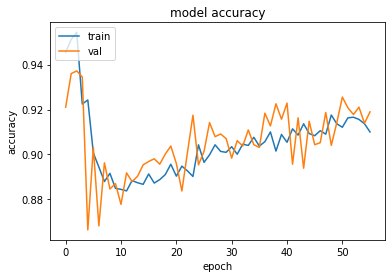

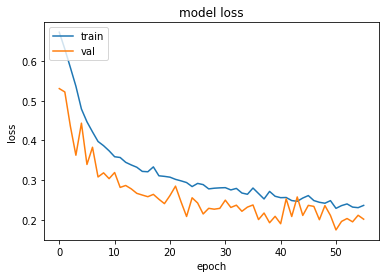

In [59]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluate

In [60]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_vectors).squeeze()
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

print(classification_report(y_test_words,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      3071
           1       0.49      0.94      0.64       274

    accuracy                           0.91      3345
   macro avg       0.74      0.93      0.80      3345
weighted avg       0.95      0.91      0.93      3345



# Inference

In [61]:
def recipe_to_target_words(recipe):
    """
        Create word list from recipe. Include 2-gram and 3-grams.
    """
    words = nltk.word_tokenize(recipe)
    #Create vector for each word
    word_vectors = np.array([ft_model.get_word_vector(word) for word in words])

    targets = []
    for i in range(len(word_vectors)):    
        
        # Calculate mean vector for n-grams.
        n_gram_1 = word_vectors[i:i+1].mean(axis=0)
        n_gram_2 = word_vectors[i:i+2].mean(axis=0)    
        n_gram_3 = word_vectors[i:i+3].mean(axis=0)
    
        targets.append((words[i], n_gram_1))
        targets.append((' '.join(words[i:i+2]), n_gram_2))
        targets.append((' '.join(words[i:i+3]), n_gram_3))
    
    return targets

word,vec = recipe_to_target_words(X_test.iloc[0].Directions)[61]
word, vec.shape

('well blended', (300,))

In [62]:
def predict(text):
    """
        Prediction function
    """
    # Get target word list
    targets = recipe_to_target_words(text)
    
    # Seperate words and vectors
    words = [t[0] for t in targets]
    vecs = np.array([np.expand_dims(t[1],axis=1) for t in targets])
    
    # Create prediciton for each word or n-gram
    y_pred = model.predict(vecs) 
    y_pred = np.squeeze(y_pred > 0.5).astype(int)
    
    result = []
    for w,p in zip(words,y_pred):
        # if prediction is 1 --> Ingredient. add to list
        if p==1:
            result.append(w)
            
    return result
    
predict(X_test.iloc[0].Directions)

['molasses',
 'brown sugar',
 'sugar',
 'sugar , baking',
 ', baking soda',
 'baking',
 'baking soda',
 'baking soda ,',
 'soda',
 'soda , ginger',
 'ginger',
 'ginger and cinnamon',
 'cinnamon',
 'cinnamon until',
 'coffee',
 'tablespoon',
 'the spice',
 'the spice mixture',
 'spice',
 'spice mixture',
 'spice mixture until',
 'coffee',
 'garnish',
 'whipped cream',
 'cream',
 'cloves']

In [63]:
from nltk.corpus import wordnet

In [64]:
def post_filter(items):    
    """
        Post filtering function of n-gram results. to have clear text
    """
    
    # Seperate multiple words by comma & "and" word
    filtered = []
    for f in items:
        if ',' in f:
            filtered += f.split(',')
        if 'and' in f:
            filtered += f.split('and')
        if 'and' not in f and ',' not in f:
            filtered.append(f)
                        
    filtered = list(set(filtered))        
    filtered = [f.strip() for f in filtered if len(f) > 0]
    
    # SINGULARIZE plural words
    filtered = [f if wordnet.morphy(f) is None else wordnet.morphy(f) for f in filtered]    
    
    # filter duplicate words by n-grams
    filtered = sorted(filtered, key=lambda x: len(x.split()), reverse=True)    

    
    # remove single word of "cup"
    ignore_items = ["cup"]
    filtered = list(set(filtered) - set(ignore_items))   
    
    return filtered

print(post_filter(predict(X_test.iloc[0].Directions)))
print(X_test.iloc[7].Ingredients)

['cream', 'the spice', 'soda', 'cinnamon', 'tablespoon', 'spice mixture', 'cinnamon until', 'brown sugar', 'molasses', 'clove', 'sugar', 'spice', 'the spice mixture', 'ginger', 'whipped cream', 'garnish', 'baking', 'coffee', 'spice mixture until', 'baking soda']
cream,milk,whiskey,coffee,chocolate,vanilla,almond


In [65]:
X_test.iloc[5].Directions

'Heat the oil in a large saucepan over medium-low heat. Slowly cook and stir the onion until tender. Mix in the garlic, jalapeno, green chile peppers, cumin, oregano and cayenne. Continue to cook and stir the mixture until tender, about 3 minutes. Mix in the chicken broth, chicken and white beans. Simmer 15 minutes, stirring occasionally. Remove the mixture from heat. Slowly stir in the cheese until melted. Serve warm. '

In [66]:
post_filter(predict('In a large bowl, combine flour, baking powder, baking soda, salt, cinnamon, nutmeg, brown sugar, and  oats. Add apple, nuts, raisins, eggs, milk, and oil.  Mix until dry ingredients are moistened.**Bake for 55 to 60 minutes, or until done.  Cool on wire rack.'))

['soda',
 'cinnamon',
 'baking powder',
 'milk',
 'raisin',
 'flour',
 'salt',
 'combine flour',
 'brown sugar',
 'apple',
 'powder',
 'sugar',
 'eggs',
 'oil',
 'nut',
 'baking',
 'nutmeg',
 'oat',
 'baking soda']

# Calculate Positions from Text

In [67]:
def create_result(text):
    ingredients = post_filter(predict(text))
    
    matches = []
    for item in ingredients:
        matches += [[item, match.start(),match.end()] for match in re.finditer(item, text)]
    
    return matches

In [68]:
create_result('In a large bowl, combine flour, baking powder, baking soda, salt, cinnamon, nutmeg, brown sugar, and  oats. Add apple, nuts, raisins, eggs, milk, and oil.  Mix until dry ingredients are moistened.**Bake for 55 to 60 minutes, or until done.  Cool on wire rack.')



[['soda', 54, 58],
 ['cinnamon', 66, 74],
 ['baking powder', 32, 45],
 ['milk', 140, 144],
 ['raisin', 125, 131],
 ['flour', 25, 30],
 ['salt', 60, 64],
 ['combine flour', 17, 30],
 ['brown sugar', 84, 95],
 ['apple', 112, 117],
 ['powder', 39, 45],
 ['sugar', 90, 95],
 ['eggs', 134, 138],
 ['oil', 150, 153],
 ['nut', 76, 79],
 ['nut', 119, 122],
 ['nut', 218, 221],
 ['baking', 32, 38],
 ['baking', 47, 53],
 ['nutmeg', 76, 82],
 ['oat', 102, 105],
 ['baking soda', 47, 58]]

In [69]:
import tensorflow
tensorflow.keras.models.save_model(model,"model_1dcnn.h5")